In [1]:
import tensorflow as tf
from tensorflow import keras 
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

DIR = 'Final'

AUTOTUNE = tf.data.AUTOTUNE

RES_HEIGHT = 24
RES_WIDTH = 32
NUM_CLASS = 5
N_BATCH =8
N_EPOCH = 100
LR = 0.0005

2024-01-07 08:10:44.347636: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-07 08:10:44.388113: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-07 08:10:45.177623: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset1_origin = np.load('npz/dataset1_origin.npz', allow_pickle=True)
dataset1_horizon = np.load('npz/dataset1_horizon.npz', allow_pickle=True)
dataset1_vertical = np.load('npz/dataset1_vertical.npz', allow_pickle=True)
dataset1_vh = np.load('npz/dataset1_vh.npz', allow_pickle=True)
dataset2_origin = np.load('npz/dataset2_origin.npz', allow_pickle=True)
dataset2_horizon = np.load('npz/dataset2_horizon.npz', allow_pickle=True)
dataset2_vertical = np.load('npz/dataset2_vertical.npz', allow_pickle=True)
dataset2_vh = np.load('npz/dataset2_vh.npz', allow_pickle=True)

d1o_origin_images, d1o_target_images, d1o_number_labels, d1o_coordinates = dataset1_origin['images'], dataset1_origin['filters'], dataset1_origin['numbers'],  dataset1_origin['coordinates']
d1h_origin_images, d1h_target_images, d1h_number_labels, d1h_coordinates = dataset1_horizon['images'], dataset1_horizon['filters'], dataset1_horizon['numbers'],  dataset1_horizon['coordinates']
d1v_origin_images, d1v_target_images, d1v_number_labels, d1v_coordinates = dataset1_vertical['images'], dataset1_vertical['filters'], dataset1_vertical['numbers'],  dataset1_vertical['coordinates']
d1vh_origin_images, d1vh_target_images, d1vh_number_labels, d1vh_coordinates = dataset1_vh['images'], dataset1_vh['filters'], dataset1_vh['numbers'],  dataset1_vh['coordinates']
d2o_origin_images, d2o_target_images, d2o_number_labels, d2o_coordinates = dataset2_origin['images'], dataset2_origin['filters'], dataset2_origin['numbers'],  dataset2_origin['coordinates']
d2h_origin_images, d2h_target_images, d2h_number_labels, d2h_coordinates = dataset2_horizon['images'], dataset2_horizon['filters'], dataset2_horizon['numbers'],  dataset2_horizon['coordinates']
d2v_origin_images, d2v_target_images, d2v_number_labels, d2v_coordinates = dataset2_vertical['images'], dataset2_vertical['filters'], dataset2_vertical['numbers'],  dataset2_vertical['coordinates']
d2vh_origin_images, d2vh_target_images, d2vh_number_labels, d2vh_coordinates = dataset2_vh['images'], dataset2_vh['filters'], dataset2_vh['numbers'],  dataset2_vh['coordinates']

origin_images = np.concatenate([d1o_origin_images, d2o_origin_images, d1h_origin_images, d2h_origin_images, d1v_origin_images, d2v_origin_images, d1vh_origin_images, d2vh_origin_images], axis = 0)
target_images = np.concatenate([d1o_target_images, d2o_target_images, d1h_target_images, d2h_target_images, d1v_target_images, d2v_target_images, d1vh_target_images, d2vh_target_images], axis = 0)
numbers_labels = np.concatenate([d1o_number_labels, d2o_number_labels, d1h_number_labels, d2h_number_labels, d1v_number_labels, d2v_number_labels, d1vh_number_labels, d2vh_number_labels], axis = 0)
coordinates = np.concatenate([d1o_coordinates, d2o_coordinates, d1h_coordinates, d2h_coordinates, d1v_coordinates, d2v_coordinates, d1vh_coordinates, d2vh_coordinates], axis = 0)

print(origin_images.shape)
print(target_images.shape)
print(numbers_labels.shape)
print(coordinates.shape)


(13276, 24, 32)
(13276, 24, 32)
(13276,)
(13276, 4, 8)


In [3]:
origin_images = origin_images.reshape(13276, 24, 32, 1)
target_images = target_images.reshape(13276, 24, 32, 1)
print(origin_images.shape)
print(target_images.shape)

(13276, 24, 32, 1)
(13276, 24, 32, 1)


In [4]:
print(origin_images.max(), origin_images.min())
print(target_images.max(), target_images.min())

origin_images = origin_images / origin_images.max()
target_images = target_images / target_images.max()

print(origin_images.max(), origin_images.min())
print(target_images.max(), target_images.min())

print(origin_images.shape)
print(target_images.shape)

255 0
255 0
1.0 0.0
1.0 0.0
(13276, 24, 32, 1)
(13276, 24, 32, 1)


In [5]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(
    origin_images, numbers_labels, test_size=0.3, random_state=42
)

In [6]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=NUM_CLASS)
    return image, label

In [7]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

2024-01-07 08:10:57.054761: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22292 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1d:00.0, compute capability: 8.6
2024-01-07 08:10:57.056399: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22292 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1f:00.0, compute capability: 8.6
2024-01-07 08:10:57.057903: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22292 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:20:00.0, compute capability: 8.6
2024-01-07 08:10:57.059392: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22292 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

In [8]:
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)

In [9]:
train_ds = train_ds.shuffle(buffer_size=len(train_images)).batch(N_BATCH).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.batch(N_BATCH).prefetch(buffer_size=AUTOTUNE)

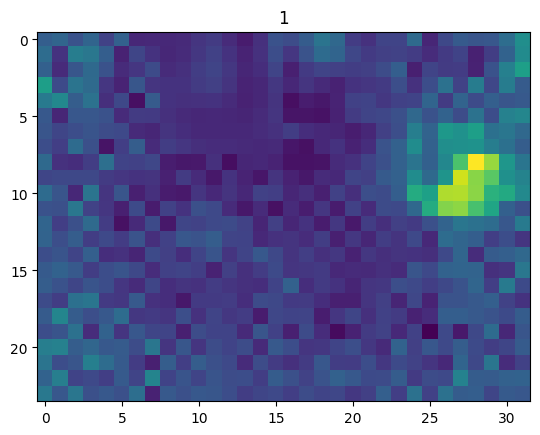

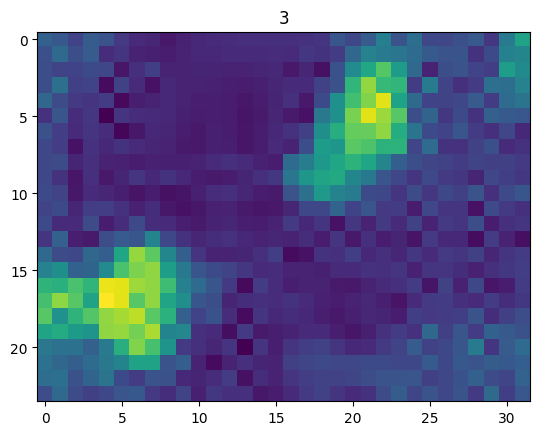

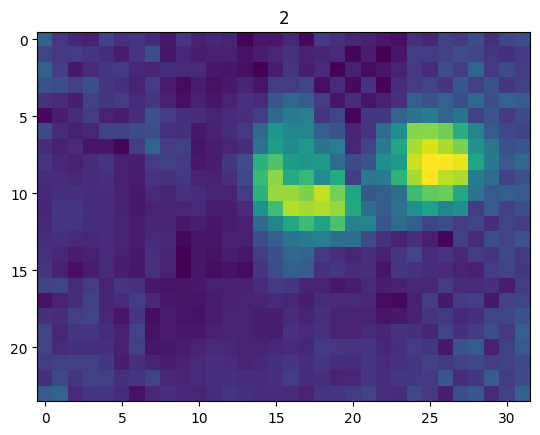

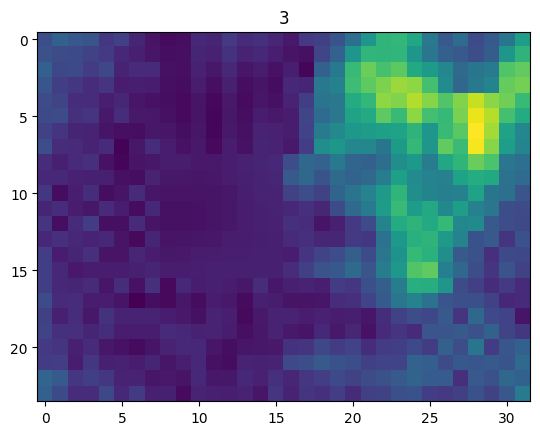

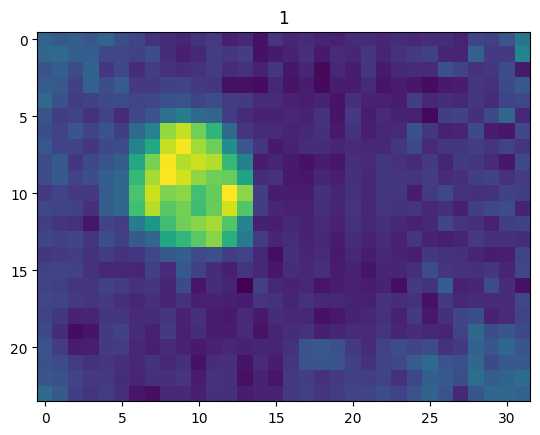

In [10]:
for images, labels in train_ds.take(5):
    plt.imshow(images[0].numpy())
    plt.title(str(labels[0].numpy().argmax()))
    plt.show()

InputLayer 			(None, 24, 32, 1)

UpSampling2D		(None, 72, 96, 1)

----------------------block 1---------------------------

Conv2D 				(None, 72, 96, 3)

BatchNormalization	(None, 72, 96, 3)

ELU					(None, 72, 96, 3)

ZeroPadding2D		(None, 73, 97, 3)

Conv2D				(None, 36, 48, 1)

BatchNormalization	(None, 36, 48, 1) 		block_1_project_BN

<br/>
<br/>

----------------------block 2---------------------------

Conv2D				(None, 36, 48, 3)

BatchNormalization	(None, 36, 48, 3)

ELU					(None, 36, 48, 3)

Conv2D				(None, 36, 48, 1)

BatchNormalization	(None, 36, 48, 1)		block_2_project_BN

Add	(OutPut-1)		(None, 36, 48, 1)		block_1_project_BN + block_2_project_BN 

<br/>
<br/>

----------------------block 3---------------------------

Conv2D				(None, 36, 48, 3)

BatchNormalization	(None, 36, 48, 3)

ELU					(None, 36, 48, 3)

ZeroPadding2D		(None, 37, 49, 3)

Conv2D				(None, 18, 24, 1)

BatchNormalization	(None, 18, 24, 1)		block_3_project_BN

<br/>
<br/>

----------------------block 4---------------------------

Conv2D				(None, 18, 24, 3)

BatchNormalization	(None, 18, 24, 3)

ELU					(None, 18, 24, 3)

Conv2D				(None, 18, 24, 1)

BatchNormalization	(None, 18, 24, 1)		block_4_project_BN

Add	(OutPut-2)		(None, 18, 24, 1)		block_3_project_BN + block_4_project_BN 

<br/>
<br/>

----------------------block 5---------------------------

Conv2D				(None, 18, 24, 3)

BatchNormalization	(None, 18, 24, 3)

ELU					(None, 18, 24, 3)

ZeroPadding2D		(None, 19, 25, 3)

Conv2D				(None, 9, 12, 1)

BatchNormalization	(None, 9, 12, 1)		block_5_project_BN


In [11]:
import tensorflow as tf
from tensorflow import keras 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
from keras.layers import Dense, Input, MaxPool2D, Conv2D, Conv2DTranspose, Flatten, Reshape, Activation
from keras.layers import BatchNormalization, Dropout, Activation, concatenate, ZeroPadding2D
from keras.models import Model
from keras.layers import Concatenate, MaxPooling2D
from keras.models import Model
from keras.layers import Multiply
from keras.layers import MultiHeadAttention


from tensorflow.keras.layers import DepthwiseConv2D, Conv2D, UpSampling2D, GlobalAveragePooling2D

from keras.layers import ZeroPadding2D
from keras.regularizers import l2
from keras.metrics import Precision, Recall
from keras.layers import Conv2D, MaxPooling2D, concatenate, Add, Lambda
from tensorflow import repeat

class BackBone:
    def __init__(self):
        self.l2_regularizer = l2(0.001)

    def residual_layer(self, feature_map, latent, name:str):
        add_layer = Add(name = name+'_output')([feature_map, latent])
        return add_layer

    def feature_extraction_block(self, feature_map, filters_conv1:int, filters_conv2:int, name:str):
        feature_map = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name)(feature_map)
        feature_map = BatchNormalization()(feature_map)
        feature_map = Activation('relu')(feature_map)
        feature_map = Dropout(0.3)(feature_map)

        feature_map = ZeroPadding2D(padding=((0, 1), (0, 1)), name=name+'_pad')(feature_map)
        feature_map = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 2, padding = 'valid', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name+'_2')(feature_map)
        feature_map = BatchNormalization()(feature_map)
        return feature_map

    def convolutional_residual_block(self, feature_map, filters_conv1:int, filters_conv2:int, name:str):
        latent = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name)(feature_map)
        latent =  BatchNormalization()(latent)
        latent = Activation('relu')(latent)
        feature_map = Dropout(0.3)(feature_map)

        latent = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name+'_2')(latent)
        latent = BatchNormalization()(latent)
        residual_block = self.residual_layer(feature_map, latent, name)
        return residual_block
    
    def resize_images(self, inputs_image):
        return tf.image.resize(inputs_image, (inputs_image.shape[1] * 3, inputs_image.shape[2] * 3))


    def __call__(self, input_shape=(24, 32, 1)):
        inputs_image = Input(shape=input_shape)
        # upsample_layer = tf.image.resize(inputs_image, [24*3, 32*3])
        upsample_layer = Conv2DTranspose(filters = 6, kernel_size = 3, strides = (3, 3), padding = 'same')(inputs_image)
        # upsample_layer = UpSampling2D(size=(3, 3))(Conv2DLayer)
        # upsample_layer = Lambda(lambda x: repeat(repeat(x, 3, axis=1), 3, axis=2))(inputs_image)
        block_1 = self.feature_extraction_block(upsample_layer, 3, 5,'block_1')
        block_1_output = self.convolutional_residual_block(block_1, 3, 5,'block_2')
        block_2 = self.feature_extraction_block(block_1_output, 3, 5, 'block_3')
        block_2_output = self.convolutional_residual_block(block_2, 3, 5, 'block_4')
        block_3_output = self.feature_extraction_block(block_2_output, 3, 3,'block_5')
        # latent = GlobalAveragePooling2D()(block_3_output)
        # latent = keras.layers.GlobalMaxPooling2D()(block_3_output)
        latent = Flatten()(block_3_output)
        # latent = Dense(64, activation='ReLU', dtype='float32')(latent)
        # latent = Dropout(0.2)(latent)
        latent = Dense(64, activation='relu', dtype='float32')(latent)
        latent = Dropout(0.2)(latent)
        number_output = Dense(5, activation='softmax', name='number_output', dtype='float32')(latent)

        model = Model(inputs_image, number_output)
        return model

In [12]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

backbone = BackBone()
model = backbone()

initial_learning_rate = LR
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5000,
    decay_rate=0.90,
    staircase=True)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=1)

# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
#     backbone = BackBone()
#     model = backbone()
#     optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#     model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy', Precision(), Recall()])
#     checkpoint = ModelCheckpoint('v4_backbone_1_best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy', Precision(), Recall()])

checkpoint = ModelCheckpoint('v4_backbone_1_best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 32, 1)]          0         []                            
                                                                                                  
 up_sampling2d (UpSampling2  (None, 72, 96, 1)            0         ['input_1[0][0]']             
 D)                                                                                               
                                                                                                  
 block_1 (Conv2D)            (None, 72, 96, 3)            30        ['up_sampling2d[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 72, 96, 3)            12        ['block_1[0][0]']         

In [13]:
# from keras.utils import plot_model

# plot_model(model, to_file='./detection_model.png', show_shapes=True, show_layer_names=True)
# Image(filename='detection_model.png')

In [14]:
qq!

SyntaxError: invalid syntax (836187322.py, line 1)

In [15]:
from tensorflow.keras.callbacks import TensorBoard

log_dir = DIR
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [16]:
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=N_EPOCH,
    verbose=1,  
    callbacks=[checkpoint, tensorboard_callback]
    # callbacks=[checkpoint, lr_reducer]
)

Epoch 1/100


2024-01-07 08:11:15.266312: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-07 08:11:16.753361: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905
2024-01-07 08:11:17.525100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-07 08:11:17.528910: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5a10f830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-07 08:11:17.528956: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-01-07 08:11:17.528969: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor

1162/1162 [==============================] - ETA: 0s - loss: 1.1795 - accuracy: 0.5502 - precision: 0.5960 - recall: 0.4363
Epoch 1: val_accuracy improved from -inf to 0.58850, saving model to v4_backbone_1_best_model.h5
1162/1162 [==============================] - 30s 18ms/step - loss: 1.1795 - accuracy: 0.5502 - precision: 0.5960 - recall: 0.4363 - val_loss: 1.0407 - val_accuracy: 0.5885 - val_precision: 0.6182 - val_recall: 0.5626
Epoch 2/100
1159/1162 [============================>.] - ETA: 0s - loss: 0.7980 - accuracy: 0.6769 - precision: 0.7007 - recall: 0.6238
Epoch 2: val_accuracy improved from 0.58850 to 0.74868, saving model to v4_backbone_1_best_model.h5
1162/1162 [==============================] - 21s 18ms/step - loss: 0.7977 - accuracy: 0.6771 - precision: 0.7008 - recall: 0.6239 - val_loss: 0.6043 - val_accuracy: 0.7487 - val_precision: 0.7653 - val_recall: 0.7253
Epoch 3/100
1162/1162 [==============================] - ETA: 0s - loss: 0.6942 - accuracy: 0.7217 - precisio

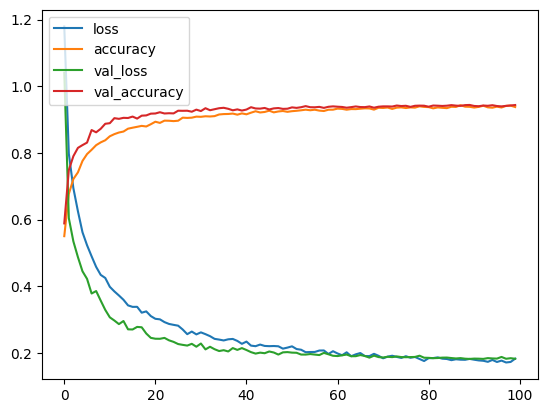

In [18]:
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['accuracy'], label = 'accuracy')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper left')

plt.savefig('47.png')

In [ ]:
qq!!   86

In [ ]:
model2.save('./v3_3().h5')

In [ ]:
import tensorflow as tf
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.sparsity.keras import UpdatePruningStep

# train_dataset, train_number_labels,

# 초기 모델 로드
model = tf.keras.models.load_model('./v1_13.h5')

# 프루닝 설정
epochs = 100
batch_size = 128
num_train_samples = origin_images.shape[0]
end_step = np.ceil(num_train_samples / batch_size).astype(np.int32) * epochs
pruning_params = {
    'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                 final_sparsity=0.80,
                                                 begin_step=0,
                                                 end_step=end_step)
}

# 모델에 프루닝 래퍼 적용
model_for_pruning = sparsity.prune_low_magnitude(model, **pruning_params)

# 프루닝 모델 컴파일 및 훈련
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.categorical_crossentropy,
                          metrics=['accuracy'])

callbacks = [
    UpdatePruningStep()
]

model_for_pruning.fit(origin_images, number_labels, epochs=epochs, callbacks=callbacks)

# 프루닝 제거 및 최종 모델 저장
final_model = sparsity.strip_pruning(model_for_pruning)
final_model.save('pruned_model.h5')


In [ ]:
final_model.summary()

In [ ]:
batch_size = 32
train_dataset_tf = tf.data.Dataset.from_tensor_slices(test_dataset)
# train_dataset을 배치로 만듦
batched_train_dataset = train_dataset_tf.batch(batch_size)

In [ ]:
import tensorflow as tf

# 기존 모델 로드
model = tf.keras.models.load_model('pruned_model.h5')

# 대표 데이터셋을 준비하는 함수
def representative_data_gen():
    for input_value in batched_train_dataset.take(100):
        yield [input_value]

# 훈련 데이터셋을 로드하고 배치 처리
# 여기서 test_dataset와 batch_size는 적절한 값으로 설정해야 합니다.
batched_train_dataset = tf.data.Dataset.from_tensor_slices(test_dataset).batch(batch_size)
batched_train_dataset = batched_train_dataset.map(lambda x: tf.cast(x, tf.float32))

# TFLite 변환기 설정
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# 모든 연산을 float32로 제한
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

# 입력과 출력을 float32로 설정
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# 모델을 TFLite 모델로 변환
tflite_quant_model = converter.convert()

# TFLite 모델 저장
with open('quantized_model.tflite', 'wb') as f:
    f.write(tflite_quant_model)
